In [149]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, matplotlib.dates as mdates, matplotlib.ticker as ticker, statsmodels.formula.api as smf, statsmodels.api as sm
sns.set(style="whitegrid", font_scale=1.5)

data = pd.read_csv("vaxUpdate.csv", parse_dates=["date"])
data["date"] = data["date"] - pd.Timedelta(days=1)
data["dayofyear"] = data["date"].dt.dayofyear

data.at[277, "act"] = (data.at[279, "act"] - data.at[276, "act"]) / 3 + data.at[276, "act"]
data.at[277, "aus"] = (data.at[279, "aus"] - data.at[276, "aus"]) / 3 + data.at[276, "aus"]
data.at[278, "act"] = (data.at[279, "act"] - data.at[276, "act"]) / 3 * 2 + data.at[276, "act"]
data.at[278, "aus"] = (data.at[279, "aus"] - data.at[276, "aus"]) / 3 * 2 + data.at[276, "aus"]

data["aus_pc"] = data.aus / (25739256 - 325331 - 326764 - 1520922 - 1635966)
data["act_pc"] = data.act / (432266 - 5593 - 5571 - 27121 - 29043)

for i in data.index:
    if data.at[i, "date"] < pd.Timestamp("2021-07-28"):
        data.at[i, "act_pc"] = data.at[i, "aus_pc"] * 1.2

data["act_doses"] = data.act_pc * (432266 - 5593 - 5571 - 27121 - 29043)

for i in data.index:
    data.at[i, "act_new"] = (data.at[i, "act_doses"] - data.at[i - 1, "act_doses"]) if i > 0 else 0

data

,date,act,aus,dayofyear,aus_pc,act_pc,act_doses,act_new
0,2021-03-22,NaN,5.075000e+03,81,0.000231,0.000278,101.342670,0.000000
1,2021-03-23,NaN,6.269000e+03,82,0.000286,0.000343,125.185655,23.842985
2,2021-03-24,NaN,1.046300e+04,83,0.000477,0.000573,208.935637,83.749982
3,2021-03-25,NaN,1.367300e+04,84,0.000623,0.000748,273.036124,64.100487
4,2021-03-26,NaN,1.550600e+04,85,0.000707,0.000848,309.639299,36.603175
...,...,...,...,...,...,...,...,...
276,2021-12-23,361202.000000,1.967861e+07,357,0.897326,0.989763,361202.000000,96.000000
277,2021-12-24,361220.333333,1.968561e+07,358,0.897646,0.989813,361220.333333,18.333333
278,2021-12-25,361238.666667,1.969262e+07,359,0.897965,0.989863,361238.666667,18.333333
279,2021-12-26,361257.000000,1.969962e+07,360,0.898284,0.989913,361257.000000,18.333333


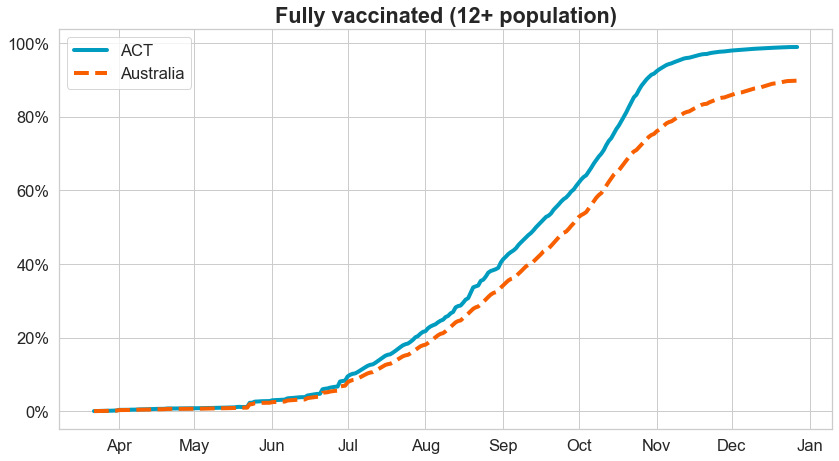

In [150]:
fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(12, 6.75)
)

sns.lineplot(data=data, x="date", y="act_pc", ax=ax, label="ACT", lw=4, color="#009CBF")
sns.lineplot(data=data, x="date", y="aus_pc", ax=ax, label="Australia", lw=4, color="#F75F00", linestyle="dashed")
# sns.scatterplot(data=data, x="date", y="act_new", ax=ax)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Fully vaccinated (12+ population)", fontsize="large", fontweight="bold")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.savefig("vax_comparison.jpg")

Intercept      -9.360799e-08
days            6.010684e-02
I(days ** 2)   -2.156019e-03
I(days ** 3)    3.263447e-05
I(days ** 4)   -2.287212e-07
I(days ** 5)    5.979566e-10
dtype: float64

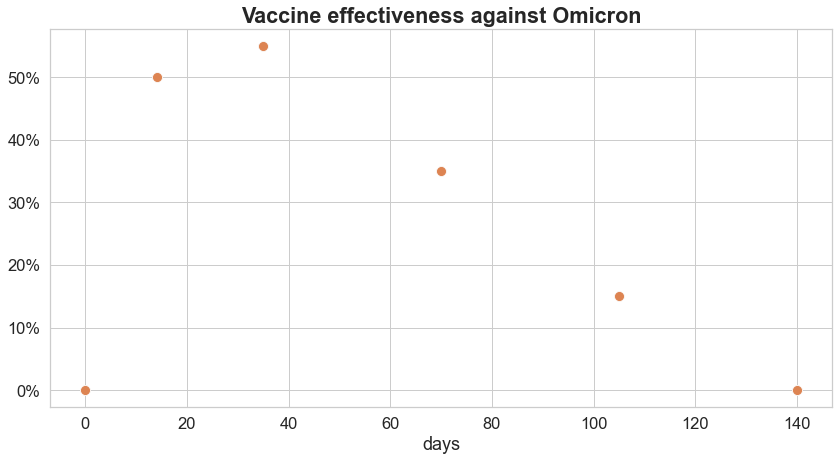

In [151]:
vax = pd.DataFrame(columns=["days", "effectiveness"], data={"days":[0, 14, 35, 70, 105, 140], "effectiveness":[0, .5, .55, .35, .15, 0]})

model = smf.ols(formula="effectiveness ~ days + I(days**2) + I(days**3) + I(days**4) + I(days**5)", data=vax).fit()

fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(12, 6.75)
)
sns.scatterplot(data=vax, x="days", y="effectiveness", ax=ax, s=100)
sns.scatterplot(data=vax, x="days", y=model.predict(), ax=ax, s=100)
# plt.xlabel(None)
plt.ylabel(None)
plt.title("Vaccine effectiveness against Omicron", fontsize="large", fontweight="bold")
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %#d"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
model.params

In [152]:
for i in data.index:
    total = 0
    for day in range(140, 0, -1):        
        if i - day in data.index:
            cases = data.at[i - day, "act_new"]
            effectiveness = model.params[0] + model.params[1] * day + model.params[2] * pow(day, 2) + model.params[3] * pow(day, 3) + model.params[4] * pow(day, 4) + model.params[5] * pow(day, 5)            
            total = total + (effectiveness * cases)
    data.at[i, "effectiveness"] = total  / (432266 - 5593 - 5571 - 27121 - 29043)
data

,date,act,aus,dayofyear,aus_pc,act_pc,act_doses,act_new,effectiveness
0,2021-03-22,NaN,5.075000e+03,81,0.000231,0.000278,101.342670,0.000000,0.000000
1,2021-03-23,NaN,6.269000e+03,82,0.000286,0.000343,125.185655,23.842985,0.000000
2,2021-03-24,NaN,1.046300e+04,83,0.000477,0.000573,208.935637,83.749982,0.000004
3,2021-03-25,NaN,1.367300e+04,84,0.000623,0.000748,273.036124,64.100487,0.000021
4,2021-03-26,NaN,1.550600e+04,85,0.000707,0.000848,309.639299,36.603175,0.000046
...,...,...,...,...,...,...,...,...,...
276,2021-12-23,361202.000000,1.967861e+07,357,0.897326,0.989763,361202.000000,96.000000,0.184064
277,2021-12-24,361220.333333,1.968561e+07,358,0.897646,0.989813,361220.333333,18.333333,0.180429
278,2021-12-25,361238.666667,1.969262e+07,359,0.897965,0.989863,361238.666667,18.333333,0.176815
279,2021-12-26,361257.000000,1.969962e+07,360,0.898284,0.989913,361257.000000,18.333333,0.173242


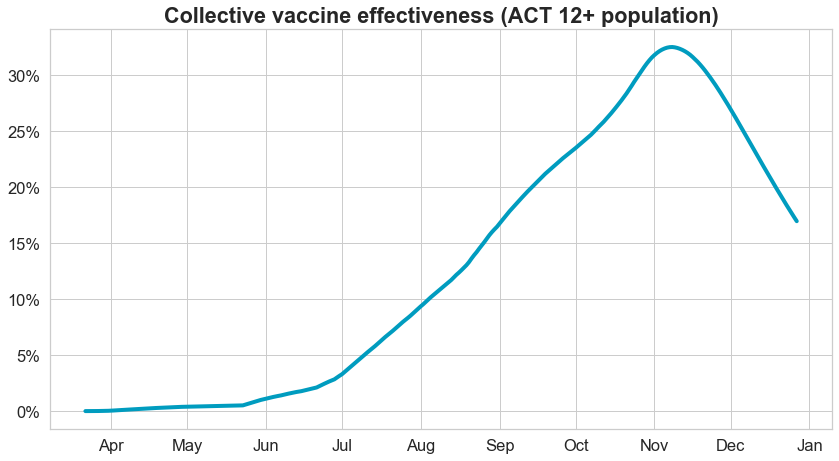

In [153]:
fig, ax = plt.subplots(
    tight_layout=True,
    figsize=(12, 6.75)
)

sns.lineplot(data=data, x="date", y="effectiveness", ax=ax, lw=4, color="#009CBF")
plt.xlabel(None)
plt.ylabel(None)
plt.title("Collective vaccine effectiveness (ACT 12+ population)", fontsize="large", fontweight="bold")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
plt.savefig("vax_effectiveness.jpg")